# RLHF Fine-Tuning for Degradation Transformer

This notebook demonstrates how to fine-tune the pre-trained Degradation Transformer using Reinforcement Learning (REINFORCE) to improve long-term trajectory prediction.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.utils import *
from torch.utils.data import DataLoader

## 1. Load Pre-trained Model
We load the model weights and configuration from the saved files.

In [2]:
import json
from safetensors.torch import load_model

# Load Config
with open('degradation_transformer_model_config.json', 'r') as f:
    config = json.load(f)

# Initialize Model Structure
model = DegradationTransformer(
    vocab_size=config['vocab_size'],
    context_window=config['context_window'],
    embedding_dim=config['embedding_dim'],
    num_heads=config['num_heads'],
    num_blocks=config['num_blocks']
)

# Load Weights
load_model(model, 'degradation_transformer_model.safetensors')
print("Model loaded successfully!")

Model loaded successfully!


## 2. Generate Data for RLHF
We generate a fresh batch of degradation episodes. We need long episodes to have enough future steps for the reward calculation.

In [ ]:
# Parameters
CONTEXT_WINDOW = config['context_window']
FUTURE_WINDOW = 20  # Length of trajectory to predict and reward
EXRA_BUFFER = 30  # Extra buffer to avoid edge effects
EPISODE_LENGTH = CONTEXT_WINDOW + FUTURE_WINDOW + EXRA_BUFFER
EPISODES_PER_PARAM = 10

# Generate Data (all laws)
data = generate_episodes_from_all_models(episode_length=EPISODE_LENGTH, episodes_per_param=EPISODES_PER_PARAM)
data.shape
#

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:48: RuntimeWarning: overflow encountered in power
  return self.c * a ** (self.m/2)
/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:92: RuntimeWarning: overflow encountered in multiply
  fx = self.alfa * a * (1 - a / self.xmax)
/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/src/utils.py:116: RuntimeWarning: invalid value encountered in power
  fx = self.beta * (a/self.alfa)**(1-self.k) * (1 - a/self.alfa)** (self.k -1)


(2183, 90)

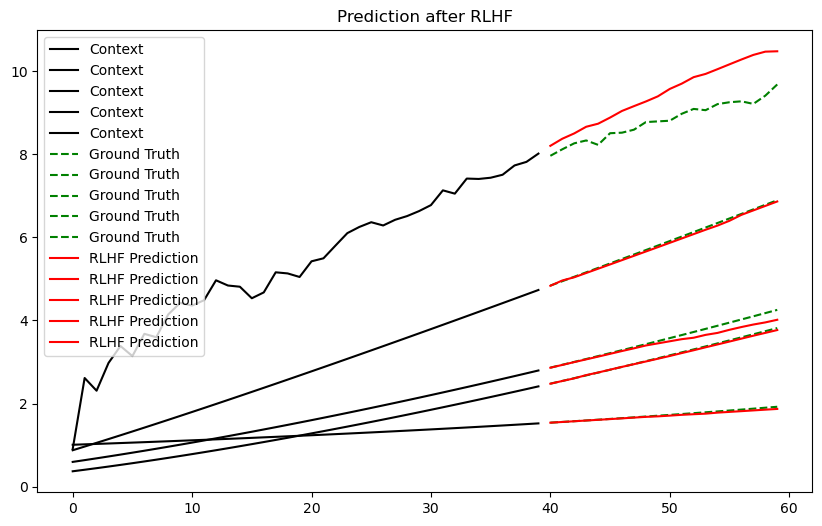

In [49]:
learner1 = Learner(model, optim=None, loss_func=None, 
                  train_loader=None, test_loader=None, cbs=[])
# Pick a random test sample
test_idx = np.random.randint(0, data.shape[0], size=5)
x_context = data[test_idx, :CONTEXT_WINDOW]
y_true = data[test_idx, CONTEXT_WINDOW:CONTEXT_WINDOW+FUTURE_WINDOW]

# Predict
y_pred,log_probs = learner1.predict(x_context, num_periods=FUTURE_WINDOW, temperature=0) # Greedy for eval

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(CONTEXT_WINDOW), x_context.T, 'k-', label='Context')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_true.T, 'g--', label='Ground Truth')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_pred.T, 'r-', label='RLHF Prediction')
plt.legend()
plt.title("Prediction after RLHF")
plt.show()


In [32]:
trajectory_log_probs = torch.stack(log_probs, dim=1).sum(dim=1)

In [39]:
trajectory_log_probs.detach().cpu().numpy().shape

(32,)

## 3. Prepare RL Dataset and Learner
We use the new `RLDataset` and `RLHFLearner`.

In [ ]:
# Create Dataset
rl_dataset = RLDataset(data, CONTEXT_WINDOW, FUTURE_WINDOW, config['vocab_size'])
train_loader = DataLoader(rl_dataset, batch_size=32, shuffle=True)

# Initialize Learner
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) # Low learning rate for fine-tuning
reward_func = MSEReward()

learner = RLHFLearner(
    model=model,
    optim=optimizer,
    reward_func=reward_func,
    train_loader=train_loader,
    cbs=[], # Add callbacks if needed
    device='mps' # or 'cuda'/'mps'
)

In [6]:
rn = next(iter(train_loader))
rn[0].shape, rn[1].shape, rn[2].shape, rn[3].shape

(torch.Size([32, 40]),
 torch.Size([32, 20]),
 torch.Size([32, 2, 1]),
 torch.Size([32, 40]))

In [7]:
len(rl_dataset), len(train_loader)

(65490, 2047)

## 4. Run RLHF Training
We run the `fit_rl` method. We use a temperature > 0 to encourage exploration during training.

In [8]:
print("Starting RLHF Fine-tuning...")
learner.fit_rl(
    num_epochs=2,
    future_window=FUTURE_WINDOW,
    temperature=1.0, # Exploration
    baseline_momentum=0.9
)

Starting RLHF Fine-tuning...
Epoch 0, Batch 0, Avg Reward: -0.1518, Loss: -2.0240
Epoch 0, Batch 10, Avg Reward: -0.4130, Loss: -19.9302
Epoch 0, Batch 20, Avg Reward: -0.4621, Loss: -14.0793
Epoch 0, Batch 30, Avg Reward: -0.2351, Loss: 1.0073
Epoch 0, Batch 40, Avg Reward: -0.4189, Loss: -12.6585
Epoch 0, Batch 50, Avg Reward: -0.1906, Loss: 2.2407
Epoch 0, Batch 60, Avg Reward: -0.3589, Loss: -6.8371
Epoch 0, Batch 70, Avg Reward: -0.2060, Loss: 1.8628
Epoch 0, Batch 80, Avg Reward: -0.4525, Loss: -14.9206
Epoch 0, Batch 90, Avg Reward: -0.3071, Loss: -7.0772
Epoch 0, Batch 100, Avg Reward: -0.3370, Loss: -5.0748
Epoch 0, Batch 110, Avg Reward: -0.4736, Loss: -19.2664
Epoch 0, Batch 120, Avg Reward: -0.1776, Loss: 1.6635
Epoch 0, Batch 130, Avg Reward: -0.0844, Loss: 7.6309
Epoch 0, Batch 140, Avg Reward: -0.2598, Loss: -5.8534
Epoch 0, Batch 150, Avg Reward: -0.3777, Loss: -14.4615
Epoch 0, Batch 160, Avg Reward: -0.2007, Loss: 4.1876
Epoch 0, Batch 170, Avg Reward: -0.2401, Loss: 

## 5. Evaluate Results
Let's compare the model's predictions after fine-tuning.

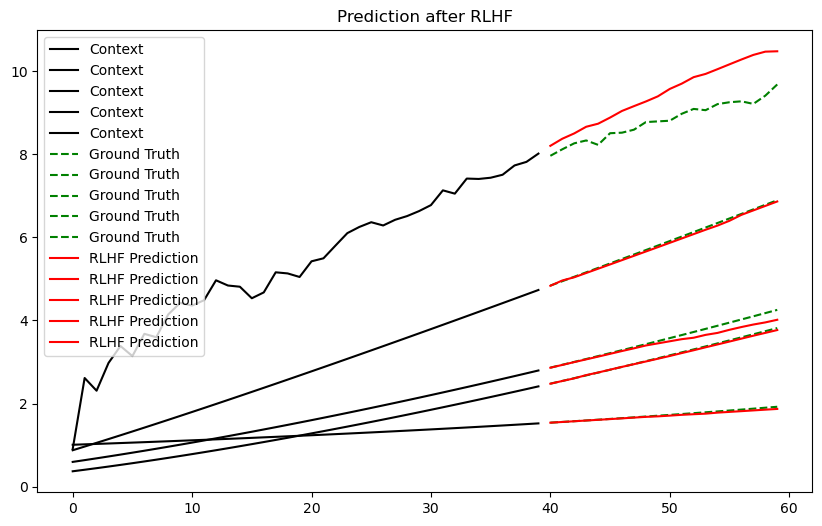

In [60]:
# Pick a random test sample

x_context = data[test_idx, :CONTEXT_WINDOW]
y_true = data[test_idx, CONTEXT_WINDOW:CONTEXT_WINDOW+FUTURE_WINDOW]
# Predict
y_pred,_ = learner.predict(x_context, num_periods=FUTURE_WINDOW, temperature=0.0) # Greedy for eval

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(CONTEXT_WINDOW), x_context.T, 'k-', label='Context')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_true.T, 'g--', label='Ground Truth')
plt.plot(np.arange(CONTEXT_WINDOW, CONTEXT_WINDOW+FUTURE_WINDOW), y_pred.T, 'r-', label='RLHF Prediction')
plt.legend()
plt.title("Prediction after RLHF")
plt.show()